# Итоговая работа "Анализ данных временных рядов

In [292]:

from ticers import Ticers
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

#t = Ticers()
#t.dowload_data('GAZP', '2020-01-01', '2022-12-01')
gazp = pd.read_csv('./data/company/GAZP_1.csv')

# Индексируем поле Data
gazp.set_index('No', inplace=True)
# Переводим текстоый формат в datetime для удобного проведения срезов
gazp.index = pd.to_numeric(gazp.index)



# Нахождение скользящего среднего

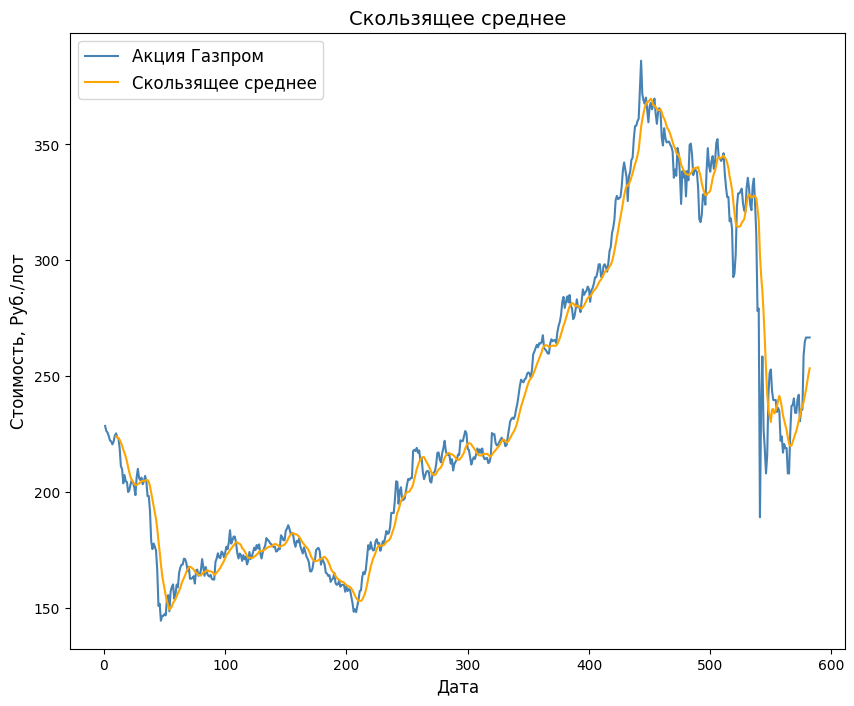

In [345]:
plt.figure(figsize = (10,8))
plt.plot(gazp['GAZP'], label = 'Акция Газпром', color = 'steelblue')

# window - наблудение через кажные 12 дней
plt.plot(gazp['GAZP'].rolling(window = 10).mean(), label = 'Скользящее среднее', color = 'orange')
plt.legend(title = '', loc = 'upper left', fontsize = 12)

# добавим подписи к осям и заголовки
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Стоимость, Руб./лот', fontsize = 12)
plt.title('Скользящее среднее', fontsize = 14)

plt.show()

# Тест Харки-Бера. Определение нормальности распределения

In [373]:
import numpy as np
from statsmodels.iolib.table import SimpleTable

row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(gazp['GAZP'])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB               p-value                skew             kurtosis    
-----------------------------------------------------------------------------
57.52858712636123 3.2197787491194166e-13 0.6195974641979118 2.085282119652063
-----------------------------------------------------------------------------


Вывод: JB>>0, распределение ошибок близко к нормальному

#  Тест Дикки-Фуллера. Определение стационарности ряда

In [347]:
adf_test = adfuller(gazp['GAZP'])
print('adf: ', adf_test[0])
print('p-value: ', adf_test[1])
print('Critical values: ', adf_test[4])
if adf_test[0]> adf_test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

# p-value = 0.70773344776174 // p > 0,05 значит ряд НЕСТАЦИОНАРНЫЙ, сезонности нет
# Следовательно, подходит модель ARIMA / ARIMAX

adf:  -1.1182647528389473
p-value:  0.7077334455512994
Critical values:  {'1%': -3.441935806025943, '5%': -2.8666509204896093, '10%': -2.5694919649816947}
есть единичные корни, ряд не стационарен


# Расширенный тест Дикки-Фуллера. Определение порядка интегрирования (d)

In [348]:
pdiff = gazp['GAZP'].diff(periods=1).dropna()

test = sm.tsa.adfuller(pdiff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.95186994204808
p-value:  2.1377358896022318e-07
Critical values:  {'1%': -3.441935806025943, '5%': -2.8666509204896093, '10%': -2.5694919649816947}
единичных корней нет, ряд стационарен


Вывод: ряд стационарен при 'periods=1', Порядок интегрирования 1

# Поиск тренда

<AxesSubplot: xlabel='No'>

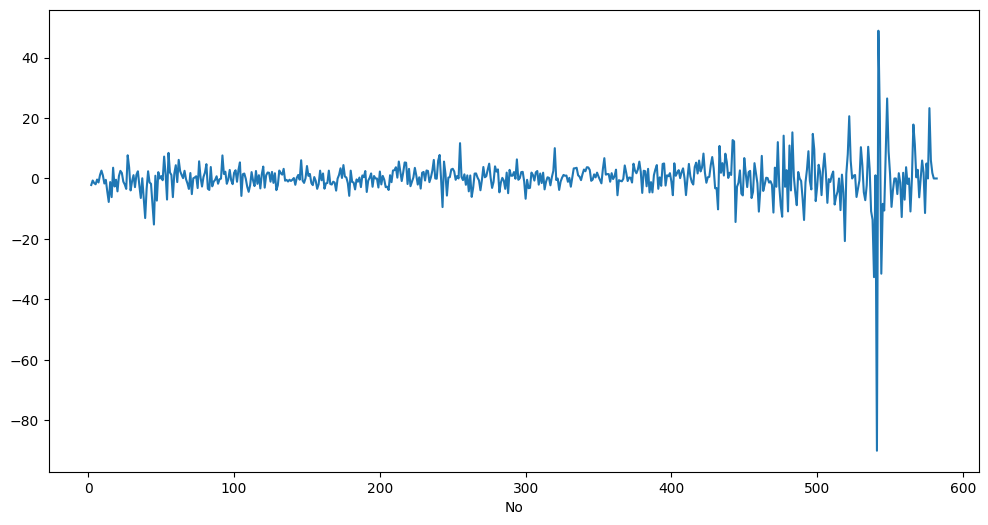

In [349]:
pdiff.plot(figsize=(12,6))

Вывод: Судя по графику ярко выроженный тренд отсутствует

# Автокорреляция. Поиск порядока компонетны MA (q) и AR (p)

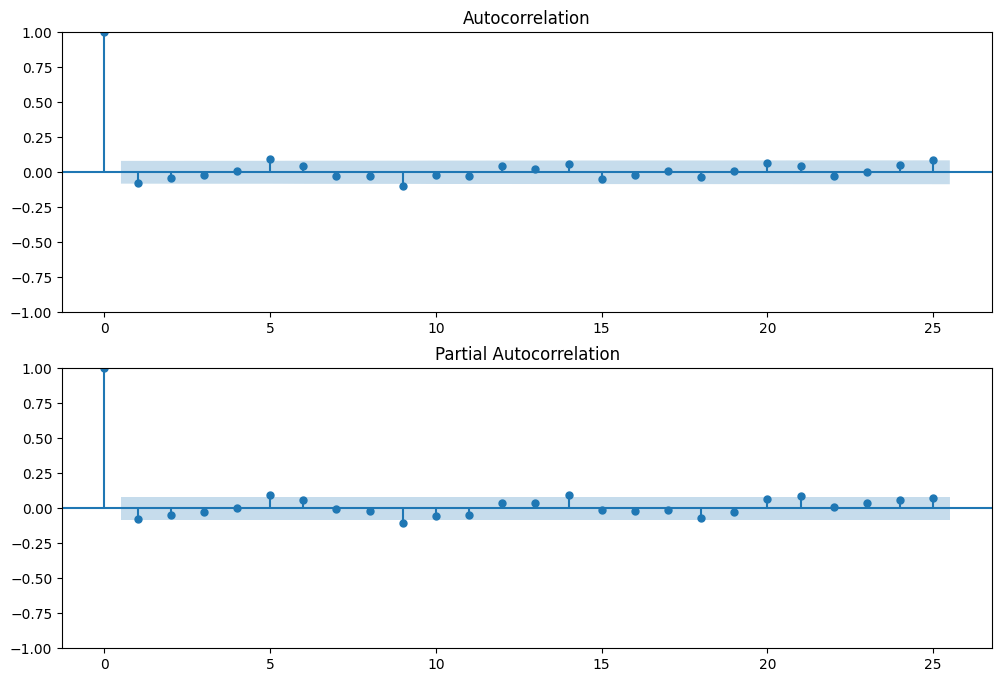

In [350]:
# импортируем функцию для построения автокорреляционной функции (ACF)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pdiff.values.squeeze(), lags=25, ax=ax1) # MA(q)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pdiff, lags=25, ax=ax2) # AR(p)

Вывод: q и p = 1, т.к. обе диаграммы имеют по 1 ярко выраженному лагу

# Построение прогноза

# Модель ARIMA

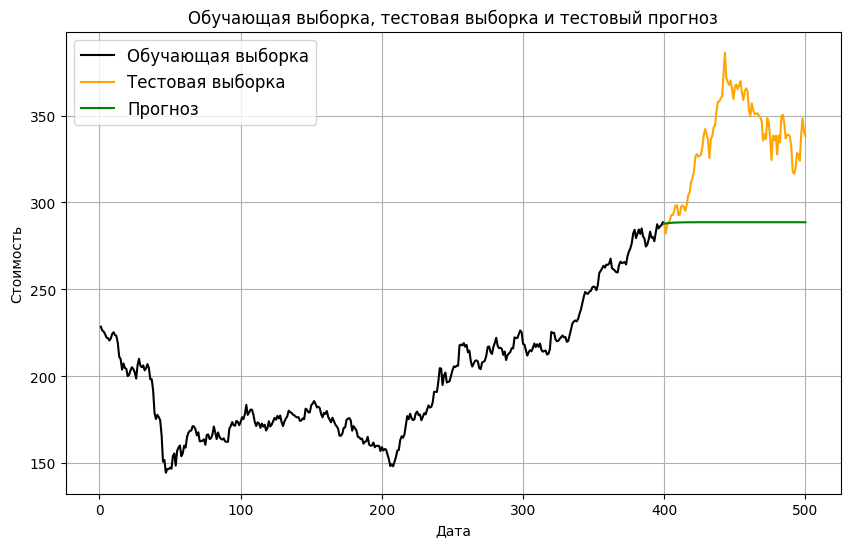

In [395]:
# Разбиваем данные на обучаущую и тестовую выборки
train = gazp.loc[:400]
test = gazp.loc[400:500]

# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = sm.tsa.ARIMA(train['GAZP'], order = (1, 1, 1))
 
# применим метод fit
result = model.fit()

# применим метод predict
predictions = result.predict(400, 500)

plt.figure(figsize = (10,6))

plt.plot(train['GAZP'], label = 'Обучающая выборка', color = 'black')
plt.plot(test['GAZP'], label = 'Тестовая выборка', color = 'orange')
plt.plot(predictions, label = 'Прогноз', color = 'green')

plt.legend(title = '', loc = 'upper left', fontsize = 12) 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Стоимость')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()
plt.show()

# Модель SARIMAX

Автопоиск параметров

In [387]:
from pmdarima import auto_arima
  
# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train['GAZP'], start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
  
# выведем результат
print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2274.559, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2114.821, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2274.582, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2081.425, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2080.395, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2113.588, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2081.402, Time=0.29 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2083.370, Time=0.55 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2082.0

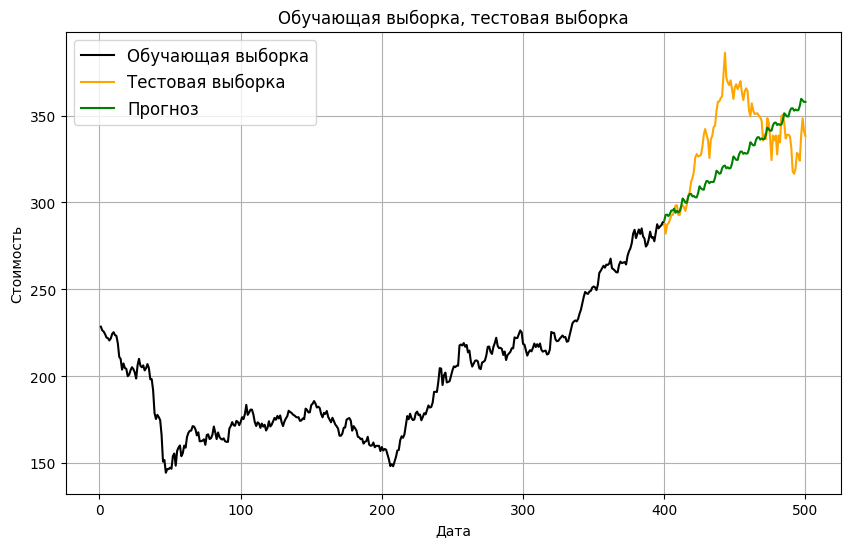

In [397]:
model = SARIMAX(train['GAZP'], 
                order = (0, 1, 0), 
                seasonal_order = (2, 1, 0, 12))
 
# применим метод fit
result = model.fit()

# применим метод predict
predictions = result.predict(400, 500)

plt.figure(figsize = (10,6))

plt.plot(train['GAZP'], label = 'Обучающая выборка', color = 'black')
plt.plot(test['GAZP'], label = 'Тестовая выборка', color = 'orange')
plt.plot(predictions, label = 'Прогноз', color = 'green')
 
plt.legend(title = '', loc = 'upper left', fontsize = 12) 
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка, прогноз")
plt.ylabel('Стоимость')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()
plt.show()

Выводы: 

    - модель SARIMAX показала себя луше
    - нужно увеличивать набор обучающих данных, тестировать с разными параметрами, пробыать новые модели

Задачи:

 1) провести кластеризацию 
 2) выделить кластер с набором данных включающий выбранную котировку
 3) обучить